<a href="https://colab.research.google.com/github/ioloi1128/CDA/blob/main/CDA_week14_wavelet_detrend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install numpy
!pip install xarray
!pip install matplotlib
!pip install scipy
!pip install pandas
!pip install tqdm
!pip install pycwt

!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install cartopy

!apt-get -V -y -qq install python-cartopy python3-cartopy
!pip uninstall shapely -y
!pip install shapely --no-binary shapely

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libproj-dev is already the newest version (4.9.3-2).
proj-bin is already the newest version (4.9.3-2).
proj-data is already the newest version (4.9.3-2).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
Found existing installation: Shapely 1.6.4
Uninstalling Shapely-1.6.4:
  Successfully uninstalled Shapely-1.6.4
     |█████████████████████

In [17]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import pycwt as wavelet
from pycwt.helpers import find

In [18]:
url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
ds = xr.open_dataset(url)

# select period
ds = ds.sel(time=slice('1900', '2020'))

#actually load the data
ds.load()

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, nbnds: 2, time: 1452)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1900-01-01 1900-02-01 ... 2020-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    sst        (time, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan
Attributes: (12/38)
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    ...                              ...
    license:                         No constraints on data access or use
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    data_modified:                   2022-05-07
    DODS_EXTRA.Unlimited_Dimension:  time

In [31]:
sst_clim = ds.sst.groupby('time.month').mean(dim='time')
sst_anom = ds.sst.groupby('time.month') - sst_clim

In [32]:
#detrend
from scipy.signal import detrend
sst_anom_detrended = xr.apply_ufunc(detrend, sst_anom.fillna(0),
                                    kwargs={'axis': 0}).where(~sst_anom.isnull())

In [33]:
ds_EP = sst_anom_detrended.sel(lat=slice(5, -5), lon=slice(190, 240))
ds_EP_mean = ds_EP.mean(dim=('lon', 'lat'))
ds_EP_mean

<xarray.DataArray 'sst' (time: 1452)>
array([ 1.7387464,  1.7267386,  1.5084795, ..., -1.1711731, -1.3661898,
       -1.2048929], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1900-01-01 1900-02-01 ... 2020-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [36]:
t0 = 1900.0
dt = 1/12  # In years

dat = ds_EP_mean.values
N = dat.size
t = np.arange(0, N) * dt + t0

print(N)

1452


In [38]:
avg1, avg2 = (2, 8)                  # Range of periods to average
slevel = 0.95                        # Significance level

std = dat.std()                      # Standard deviation
std2 = std ** 2                      # Variance
dat = (dat - dat.mean()) / std       # Calculating anomaly and normalizing

N = dat.size                            # Number of measurements
time = np.arange(0, N) * dt + t0  # Time array in years



In [39]:
# set up parameters

mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 0.25 years = 6 months
dj = 1 / 12  # Twelve sub-octaves per octaves
J  = 7 / dj  # Seven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise
print(dat.flags)

  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False



In [40]:
# do wavelet transform

wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat, dt, dj, s0, J, mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std

In [41]:
# do FFT spectrum
power = (np.abs(wave)) ** 2
fft_power = np.abs(fft) ** 2
period = 1 / freqs

In [42]:
# 
signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig95 = np.ones([1, N]) * signif[:, None]
sig95 = power / sig95

In [43]:
glbl_power = power.mean(axis=1)
dof = N - scales  # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(std2, dt, scales, 1, alpha,
                                        significance_level=0.95, dof=dof,
                                        wavelet=mother)

In [44]:
sel = find((period >= 2) & (period < 8))
Cdelta = mother.cdelta
scale_avg = (scales * np.ones((N, 1))).transpose()
scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
scale_avg = std2 * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(std2, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)

In [45]:
title = 'EP Sea Surface Temperature'
label = 'EP SST'
units = 'degC'

# Prepare the figure
plt.close('all')
plt.ioff()
figprops = dict(figsize=(11, 8), dpi=72)
fig = plt.figure(**figprops)

# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
ax = plt.axes([0.1, 0.75, 0.65, 0.2])
ax.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
ax.plot(t, dat, 'k', linewidth=1.5)
ax.set_title('a) {}'.format(title))
ax.set_ylabel(r'{} [{}]'.format(label, units))
#plt.show()



/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'EP SST [degC]')

In [46]:
# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influece hatched area. Note that period
# scale is logarithmic.
bx = plt.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels),
            extend='both', cmap=plt.cm.viridis)
extent = [t.min(), t.max(), 0, max(period)]
bx.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
           extent=extent)
bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                           np.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
bx.set_ylabel('Period (years)')
#
Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                           np.ceil(np.log2(period.max())))
bx.set_yticks(np.log2(Yticks))
bx.set_yticklabels(Yticks)
#plt.show()


[Text(0, 0, '0.25'),
 Text(0, 0, '0.5'),
 Text(0, 0, '1.0'),
 Text(0, 0, '2.0'),
 Text(0, 0, '4.0'),
 Text(0, 0, '8.0'),
 Text(0, 0, '16.0')]

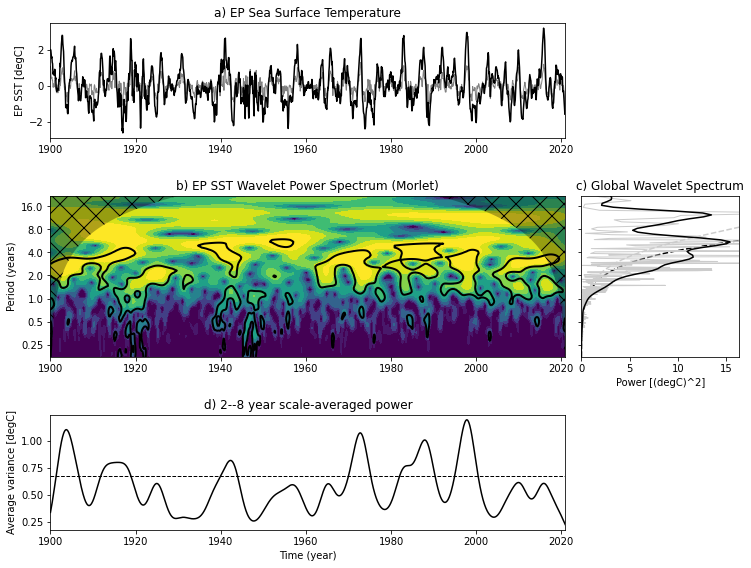

In [47]:
var = std2
# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = plt.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
cx.plot(glbl_signif, np.log2(period), 'k--')
cx.plot(var * fft_theor, np.log2(period), '--', color='#cccccc')
cx.plot(var * fft_power, np.log2(1./fftfreqs), '-', color='#cccccc',
        linewidth=1.)
cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5)
cx.set_title('c) Global Wavelet Spectrum')
cx.set_xlabel(r'Power [({})^2]'.format(units))
cx.set_xlim([0, glbl_power.max() + var])
cx.set_ylim(np.log2([period.min(), period.max()]))
cx.set_yticks(np.log2(Yticks))
cx.set_yticklabels(Yticks)
plt.setp(cx.get_yticklabels(), visible=False)

# Fourth sub-plot, the scale averaged wavelet spectrum.
dx = plt.axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
dx.plot(t, scale_avg, 'k-', linewidth=1.5)
dx.set_title('d) {}--{} year scale-averaged power'.format(2, 8))
dx.set_xlabel('Time (year)')
dx.set_ylabel(r'Average variance [{}]'.format(units))
ax.set_xlim([t.min(), t.max()])

plt.show()